In [2]:
# import opencv
import cv2
# import mediapipe for pose estimation libraries and mediapipe solutions
import mediapipe as mp 
# import numpy for trigonometry
import numpy as np # import numpy
# time library needed for delay
import time
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pycaret.classification import *

#pd.set_option('display.max_columns', 1000)
#pd.set_option('display.max_rows', 1000)

# set up mediapipe
# import drawing_utils for drawing utility
mp_drawing = mp.solutions.drawing_utils 
# import pose for estimation models
mp_pose = mp.solutions.pose

In [3]:
# loading saved model
predict = load_model('FPModel')

Transformation Pipeline and Model Successfully Loaded


In [4]:
# function for predicting power smashing
def will_smash(dat):
    result = []
    pred = predict_model(predict, data=dat)
    frame = pd.DataFrame(pred)
    result.append(frame['Label'].values[0])
    result.append(frame['Score'].values[0])
    
    
    #return result
    return result

In [5]:
# function for calculating angle
# I took it from somewhere! Fine. I'm not going to update the comments!
def calculate_angle(a,b,c):
    '''How to calculate angles of joints'''
    a = np.array(a) # First point (hip)
    b = np.array(b) # Mid point (knee)
    c = np.array(c) # End point (ankle)
    
    # Y.ankle - Y.knee , X.ankle - X.knee  -  Y.knee - Y.hip , X.knee - X. hip
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    #converting radians to degrees
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0: #max angle is 180
        angle = 360-angle
        
    return angle

# Final Visualization

In [36]:
cap = cv2.VideoCapture('./test/test-smash4.mp4')


###########################################################################################
# Global ariables

# # counter variable for previous end of line for drawing flight path
# xp, yp = 0, 0

# # counter variable for checking end of flight path for saving flight path image
# final_y = 1000

# counter variable for checking kick before touching ball
smash_counter = 0
arm_stage = None

# # global variables for speed
# speed = 0
# final_speed_list = [0]
# max_speed = 0

# global variable for angles
angle_r_wrist = 0
angle_l_wrist = 0
angle_r_hip = 0
angle_l_hip = 0
angle_r_shoulder = 0
angle_l_shoulder = 0
angle_r_elbow = 0
angle_l_elbow = 0

# global variable for ret
# ret is a variable from openCV to check if video is at last frame
# is ret = False, there are no more frames left in the video and program should cut

ret = True

###########################################################################################
# list for storing speed and prediction
speed_list = []

prediction = [None]

###########################################################################################
# Object Detection
# object_detector = cv2.createBackgroundSubtractorMOG2(history = 100, varThreshold = 20)

###########################################################################################
# Image Canvas
imgCanvas = np.zeros((1080, 1920, 3), np.uint8)

###########################################################################################
# create blank dictionary for storing angle values


anglesDict_freeze = { 'RW':[], 'LW':[], 'RE':[], 'LE':[], 'RS':[], 'LS':[], 'RH':[], 'LH':[]}



###########################################################################################
## Setup mediapipe instance
with mp_pose.Pose(smooth_landmarks = True, min_detection_confidence=0.6, min_tracking_confidence=0.6) as pose:
    
    while True:
        
        ret, frame = cap.read()

        if ret == False:
            cap.release()
            cv2.destroyAllWindows()
            break
        
        #print('ret', ret)
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        
        #region of interest -- range of height, range of length in pixel.
        # Davinci output = 1080 by 1920
#         roi = image[0:1030, 1200: 1500]
        
        # Extract landmarks
        
        ###########################################################################################
        # RIGHT ELBOW
        ###########################################################################################
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            r_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,
                     landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
            r_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,
                      landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
            r_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,
                       landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
            
            # Calculate angle
            angle_r_elbow = "{:.2f}".format(calculate_angle(r_wrist, r_elbow, r_shoulder))
            
            # Visualize angle
            cv2.putText(image, str(angle_r_elbow), 
                           tuple(np.multiply(r_elbow, [1920, 1080]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA
                                )
            print(f'Image {i}','Right elbow angle: ',angle_r_elbow)
            right_elbow.append(angle_r_elbow)
                       
        except:
            pass
        
        ###########################################################################################
        # LEFT ELBOW
        ###########################################################################################
        
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            l_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,
                     landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
            l_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,
                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
            l_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,
                       landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            
            # Calculate angle
            angle_l_elbow = "{:.2f}".format(calculate_angle(l_wrist, l_elbow, l_shoulder))
            
            # Visualize angle
            cv2.putText(image, str(angle_l_elbow), 
                           tuple(np.multiply(l_elbow, [1920, 1080]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA
                                )
            print(f'Image {i}','Left elbow angle: ',angle_l_elbow)
            left_elbow.append(angle_l_elbow)
                      
        except:
            pass

        ###########################################################################################
        # RIGHT HIP ANGLE
        ###########################################################################################
        
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            r_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,
                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
            r_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,
                     landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
            r_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,
                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
            
            # Calculate angle
            angle_r_hip = "{:.2f}".format(calculate_angle(r_shoulder, r_hip, r_knee))
            
            # Visualize angle
            cv2.putText(image, str(angle_r_hip), 
                           tuple(np.multiply(r_hip, [1920, 1080]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA
                                )
            print(f'Image {i}','Right hip angle: ',angle_r_hip)
            right_hip.append(angle_r_hip)
                       
        except:
            pass

        ###########################################################################################
        # LEFT HIP ANGLE
        ###########################################################################################
        
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            l_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,
                          landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            l_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,
                     landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
            l_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,
                      landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
            
            
            # Calculate angle
            angle_l_hip = "{:.2f}".format(calculate_angle(l_shoulder, l_hip, l_knee))
            
            # Visualize angle
            cv2.putText(image, str(angle_l_hip), 
                           tuple(np.multiply(l_hip, [1920, 1080]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA
                                )
            print(f'Image {i}','Left hip angle: ',angle_l_hip)
            left_hip.append(angle_l_hip)
                       
        except:
            pass
        
        ###########################################################################################
        # LEFT SHOULDER
        ###########################################################################################
        
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            l_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,
                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
            l_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,
                       landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            l_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
            
            # Calculate angle
            angle_l_shoulder = "{:.2f}".format(calculate_angle(l_elbow, l_shoulder, l_hip))
            
            # Visualize angle
            cv2.putText(image, str(angle_l_shoulder), 
                           tuple(np.multiply(l_shoulder, [1920, 1080]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA
                                )
            print(f'Image {i}','Left shoulder angle: ',angle_l_shoulder)
            left_shoulder.append(angle_l_shoulder)
            
                       
        except:
            pass
        
        ###########################################################################################
        # RIGHT SHOULDER
        ###########################################################################################
        
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            r_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,
                      landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
            r_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,
                       landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
            r_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,
                        landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
            
            # Calculate angle
            angle_r_shoulder = "{:.2f}".format(calculate_angle(r_elbow, r_shoulder, r_hip))
            
            # Visualize angle
            cv2.putText(image, str(angle_r_shoulder), 
                           tuple(np.multiply(r_shoulder, [1920, 1080]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA
                                )
            print(f'Image {i}','Right shoulder angle: ',angle_r_shoulder)
            right_shoulder.append(angle_r_shoulder)
            
                       
        except:
            pass
        
        ###########################################################################################
        # RIGHT WRIST ANGLE
        ###########################################################################################

        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            r_index = [landmarks[mp_pose.PoseLandmark.RIGHT_INDEX.value].x,
                      landmarks[mp_pose.PoseLandmark.RIGHT_INDEX.value].y]
            r_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,
                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
            r_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,
                        landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
            
            # Calculate angle
            angle_r_wrist = "{:.2f}".format(calculate_angle(r_elbow, r_wrist, r_index))
            
            # Visualize angle
            cv2.putText(image, str(angle_r_wrist), 
                           tuple(np.multiply(r_wrist, [1920, 1080]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA
                                )
            print(f'Image {i}','Right wrist angle: ',angle_r_wrist)
            right_wrist.append(angle_r_wrist)
                       
        except:
            pass        
        
        
        
        
        ###########################################################################################
        # LEFT WRIST ANGLE
        ###########################################################################################
        
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            l_index = [landmarks[mp_pose.PoseLandmark.LEFT_INDEX.value].x,
                      landmarks[mp_pose.PoseLandmark.LEFT_INDEX.value].y]
            l_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,
                       landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
            l_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
            
            # Calculate angle
            angle_l_wrist = "{:.2f}".format(calculate_angle(l_elbow, l_wrist, l_index))
            
            # Visualize angle
            cv2.putText(image, str(angle_l_wrist), 
                           tuple(np.multiply(l_wrist, [1920, 1080]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA
                                )
            print(f'Image {i}','Right Left angle: ',angle_l_wrist)
            left_wrist.append(angle_l_wrist)
            print('\n')
                       
        except:
            pass        
 
        
        
        ###########################################################################################
        # Convert angle to int
        
        counter_angle = float(angle_r_elbow)
#         ###########################################################################################
#         # Render detections
#         mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
#                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
#                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
#                                  )               
      
#         ###########################################################################################
#         # masking for object detector
#         mask = object_detector.apply(roi)
#         contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#         for cnt in contours:
            
#             # Calculate area to remove small elements in mask
#             area = cv2.contourArea(cnt)
#             #print(cnt)
#             # area of soccerball
#             if 130 > area > 110:
#                 #cv2.drawContours(roi, [cnt], -1, (0,255,0), 2)
#                 x, y, w, h = cv2.boundingRect(cnt)
#                 cv2.rectangle(roi, (x,y), (x + w, y + h), (0, 255, 0), 3)
#                 #print(x,y)
                
#         ##########################################################################################
#         # drawing red circle to track
#         #cv2.line(image, (xp, yp), (x,y), (0, 0, 255),50)
#         # need to add ROI start coordinates to x and y position
#         # change number to adjust to overlay over soccer ball        
#                 x = 1207 + x
#                 y = 8 + y
#                 cv2.circle(image, (x, y), 10, (0, 0, 255),3)
                
#                 if xp == 0 and yp ==0:
#                     xp, yp = x, y
#                     #print(x,y)
#                     #print(xp,yp)
                    
#         ##########################################################################################            
#         # drawing tracking line
        
#                 if x - xp > 10:
#                     print("Track out of bounds")
#                 else:
                
#                     cv2.line(image, (xp,yp), (x,y), (0, 0, 255),3 )
#                     cv2.line(imgCanvas, (xp,yp), (x,y), (0, 0, 255),3 )
#                     #print('x1',x,'y1',y)
#                     #print('xp before',xp,'yp before',yp)
                    
#                     # speed calculation
#                     # 10 pixels = 20cm
#                     # 1 pixel = 2cm
#                     # the video is taken at 120fps, it will be 4x slower than a normal 30fps video
#                     # thus 1 pixel = 2 x 4 = 8cm
                    
#                     speed_calc = ((yp - y) * 8)/10
#                     speed = speed_calc
#                     speed_list.append(speed)
#                     final_speed_list = [x for x in speed_list if x < np.mean(speed_list) + 3*np.std(speed_list)]
#                     max_speed = max(final_speed_list, default=0)
                    
#                     xp, yp = x, y
#                     final_y = y
#                     #print(x,y)
#                     #print(xp,yp)
#         ##########################################################################################
#         # code needed for drawing directly on opencv main frame
        
        
#         imgGray = cv2.cvtColor(imgCanvas,cv2.COLOR_BGR2GRAY)
#         _, imgInv = cv2.threshold(imgGray, 50, 255, cv2.THRESH_BINARY_INV)
#         imgInv = cv2.cvtColor(imgInv, cv2.COLOR_GRAY2BGR)
#         image = cv2.bitwise_and(image, imgInv)
#         image = cv2.bitwise_or(image, imgCanvas)

        
        ##########################################################################################
        # Draw boxes fot indication on Video
        
        
        # for RIGHT WRIST
        cv2.rectangle(image, (0,0), (150,73), (245,117,16), -1)
        
        # for LEFT WRIST
        cv2.rectangle(image, (151,0), (301,73), (245,117,16), -1)
        
        # for RIGHT ELBOW
        cv2.rectangle(image, (302,0), (452,73), (245,117,16), -1)
        
        # for LEFT ELBOW
        cv2.rectangle(image, (453,0), (603,73), (245,117,16), -1)
        
        # for RIGHT SHOULDER
        cv2.rectangle(image, (603,0), (754,73), (245,117,16), -1)
        
        # for LEFT SHOULDER
        cv2.rectangle(image, (755,0), (905,73), (245,117,16), -1)
        
        # for RIGHT HIP
        cv2.rectangle(image, (0,74), (205,140), (245,117,16), -1)
        
        # for LEFT HIP
        cv2.rectangle(image, (206,74), (411,140), (245,117,16), -1)
        
        # for smash prediction
        cv2.rectangle(image, (412,74), (635,140), (245,117,16), -1)
    


        
        ##########################################################################################
      
        # Printing readings on screen
        cv2.putText(image, 'Right Wrist Angle', 
                    (15,15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA
                   )
        # Printing Right Wrist Angle on screen
        cv2.putText(image, str(angle_r_wrist), 
                    (10,60),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA
                   )
        ##########################################################################################
        # Printing Left Wrist Angle label on screen
        cv2.putText(image, 'Left Wrist Angle', 
                    (166,15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA
                   )
        # Printing Left Wrist Angle on screen
        cv2.putText(image, str(angle_l_wrist), 
                    (161,60),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA
                   )
        ##########################################################################################

        
        # for Right ELBOW
        cv2.rectangle(image, (453,0), (603,73), (245,117,16), -1)
        # Printing Right Elbow Angle label on screen
        cv2.putText(image, 'Right Elbow Angle', 
                    (317,15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA
                   )
        # Printing Right Elbow Angle on screen
        cv2.putText(image, str(angle_r_elbow), 
                    (312,60),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA
                   )
        ##########################################################################################
        # Printing Left Elbow Angle label on screen
        cv2.putText(image, 'Left Elbow Angle', 
                    (463,15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA
                   )
        # Printing Left Elbow Angle on screen
        cv2.putText(image, str(angle_l_elbow), 
                    (463,60),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA
                   )
        #########################################################################################                
        # for smash prediction
        cv2.rectangle(image, (412,74), (635,140), (245,117,16), -1)
        # Printing Right Shoulder Angle label on screen
        cv2.putText(image, 'Right Shoulder Angle', 
                    (618,15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA
                   )
        # Printing Right Shoulder Angle on screen
        cv2.putText(image, str(angle_r_shoulder), 
                    (613,60),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA
                   )
        ##########################################################################################
        # Printing Left Shoulder Angle label on screen
        cv2.putText(image, 'Left Shoulder Angle', 
                    (768,15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA
                   )
        # Printing Left Shoulder Angle on screen
        cv2.putText(image, str(angle_l_shoulder), 
                    (765,60),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA
                   )
         ##########################################################################################
        # Printing Right Hip Angle label on screen
        cv2.putText(image, 'Right Shoulder Angle', 
                    (12,85),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA
                   )
        # Printing Right Hip Angle on screen
        cv2.putText(image, str(angle_r_hip), 
                    (15,127),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA
                   )
        ##########################################################################################
        # Printing Left Hip Angle label on screen
        cv2.putText(image, 'Left Shoulder Angle', 
                    (210,85),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA
                   )
        # Printing Left Hip Angle on screen
        cv2.putText(image, str(angle_l_hip), 
                    (210,127),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA
                   )
        ##########################################################################################
        # Printing Smash Prediction label on screen
        cv2.putText(image, 'Smash Prediction', 
                    (420,85),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA
                   )
        # Printing m/s on screen
#         cv2.putText(image, 'm/s', 
#                     (423,127),
#                     cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA)
        
        
        ##########################################################################################
        # check for knee angle and save image and all angle values before foot hits ball
        if 1 <counter_angle < 90 and arm_stage == None:
            arm_stage = "up"
            cv2.imwrite('./test/stored_image.jpg', image)
            print('stored saved')
        
        if counter_angle > 175 and arm_stage == "up":
            arm_stage = "down"
            smash_counter += 1
            print(smash_counter)
            
            
            
            # before foot strikes the ball, append all angles
            anglesDict_freeze["RW"].append(angle_r_wrist)
            anglesDict_freeze["LW"].append(angle_l_wrist)
            anglesDict_freeze["RE"].append(angle_r_elbow)
            anglesDict_freeze["LE"].append(angle_l_elbow)
            anglesDict_freeze["RS"].append(angle_r_shoulder)
            anglesDict_freeze["LS"].append(angle_l_shoulder)
            anglesDict_freeze["RH"].append(angle_r_hip)
            anglesDict_freeze["LH"].append(angle_l_hip)
            
            # predict Power Smash or no not
            df_dat = pd.DataFrame(anglesDict_freeze)
            prediction = will_smash(df_dat)
            print(prediction)
            
            # before smash, save picture
            cv2.imwrite('./test/angles_release.jpg', image)
            print('release saved')
                    
                    
            
        ##########################################################################################
        # printing prediction on screen

        
        if prediction[0] == 1:
            # Printing prediction on screen
            cv2.putText(image, 'Power Smash', 
                    (423,127),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA
                   )
        elif prediction[0] == 0:
            # Printing prediction on screen
            cv2.putText(image, 'No Power', 
                    (423,127),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA
                   )
        else:
            # Printing prediction on screen
            cv2.putText(image, 'Waiting...', 
                    (423,127),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA
                   )
            
        ##########################################################################################
#         # save image at end of flight path
        cv2.imwrite('./test/final_image.jpg', image)
        

        ##########################################################################################
        # show image
        
        cv2.imshow('Frame', image)
        #cv2.imshow('Mask', mask)
        #cv2.imshow('Canvas', imgCanvas)
        
        ##########################################################################################
        #key presses for actions
        key = cv2.waitKey(1)
        
        # close all windows
        if cv2.waitKey(1) & key == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            break

stored saved
1
[1, 0.5681]
release saved


In [28]:
# run to close all windows after video stops
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

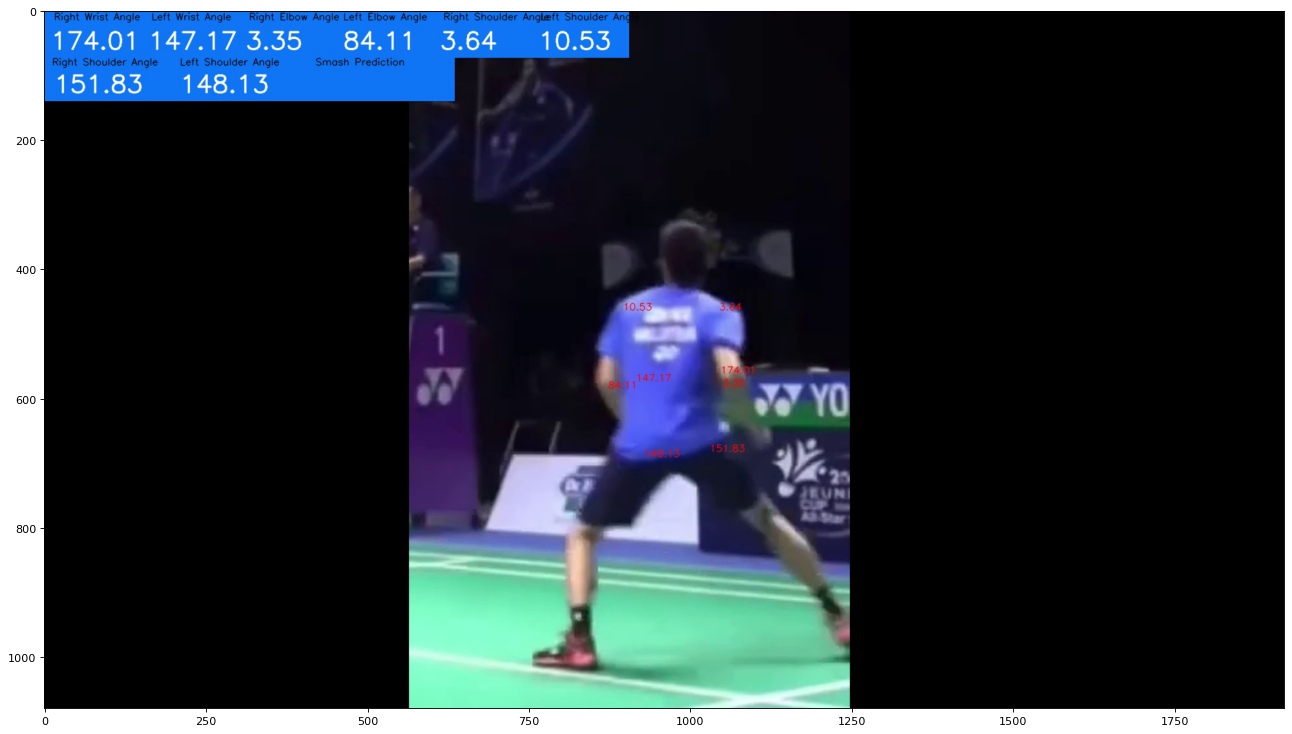

In [29]:
# print saved pose
img = mpimg.imread('./test/stored_image.jpg')
figure(figsize=(20, 15), dpi=80)
imgplot = plt.imshow(img)
plt.show()

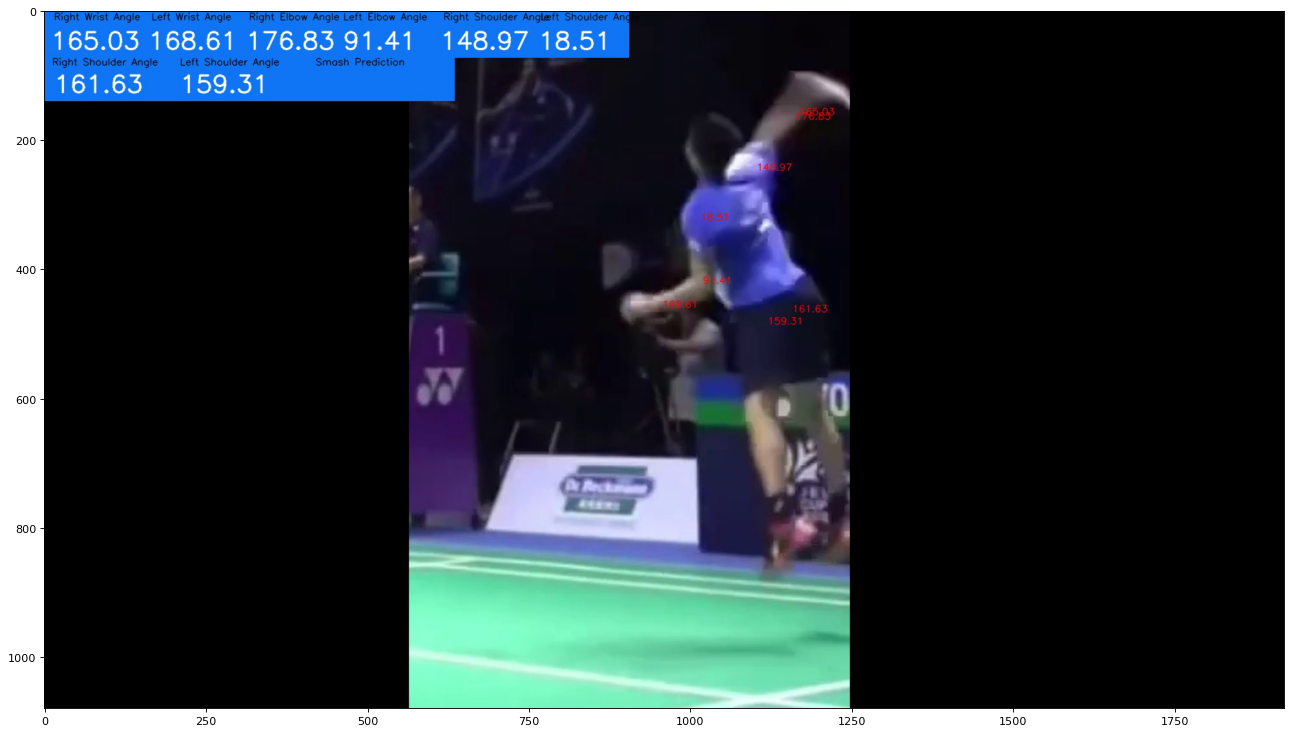

In [30]:
# print saved pose
img = mpimg.imread('./test/angles_release.jpg')
figure(figsize=(20, 15), dpi=80)
imgplot = plt.imshow(img)
plt.show()

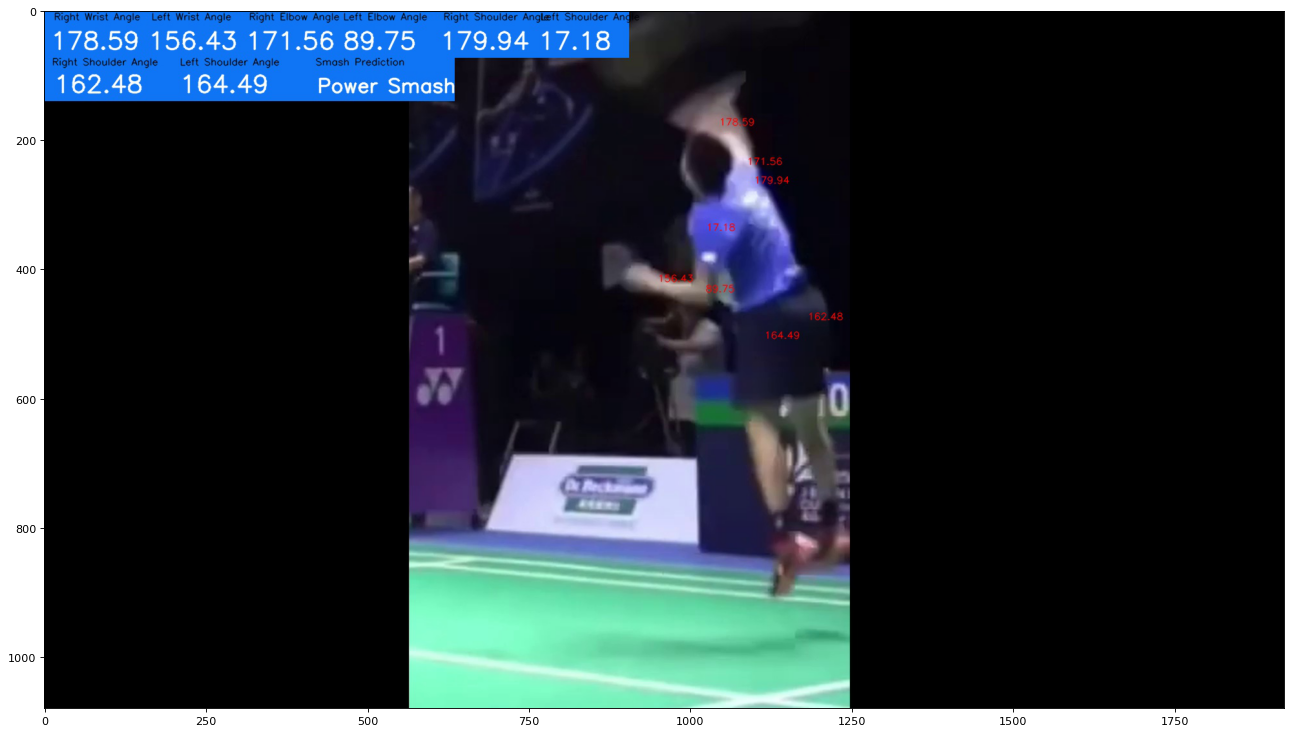

In [37]:
# print saved pose
img = mpimg.imread('./test/final_image.jpg')
figure(figsize=(20, 15), dpi=80)
imgplot = plt.imshow(img)
plt.show()